<a href="https://colab.research.google.com/github/BrothaaEww/sec_proj/blob/main/USElections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install geopandas

In [ ]:
pip install langdetect

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import missingno as msno
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk, re, string, collections, unicodedata
# %matplotlib inline
from shapely.geometry import Point, Polygon
from matplotlib import cm, dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from datetime import datetime, timedelta
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from langdetect import detect
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# for dirname, _, filenames in os.walk('F:/pythonProject/US_Elections/inputs'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Reading both the csv files
tweets_biden = pd.read_csv('/content/drive/MyDrive/hashtag_joebiden.csv', lineterminator='\n', parse_dates=True)
tweets_trump = pd.read_csv('/content/drive/MyDrive/hashtag_donaldtrump.csv', lineterminator='\n', parse_dates=True)

# Clean data
tweets_biden['country'].replace({'United States':'United States of America'}, inplace=True)
tweets_trump['country'].replace({'United States':'United States of America'}, inplace=True)


# Add Features
def normalise(x,y):
    x = np.array(x)
    y = np.array(y)
    return np.where(x == 0, 0, x / y)

def sentiment(data):
    temp=[]
    for row in data:
        tmp=sid.polarity_scores(row)
        temp.append(tmp)
    return temp

# convert to datetime object
tweets_biden['user_join_date']=pd.to_datetime(tweets_biden['user_join_date'])
tweets_trump['user_join_date']=pd.to_datetime(tweets_trump['user_join_date'])
tweets_biden['collected_at']=pd.to_datetime(tweets_biden['collected_at'])
tweets_trump['collected_at']=pd.to_datetime(tweets_trump['collected_at'])
tweets_biden['created_at']=pd.to_datetime(tweets_biden['created_at'])
tweets_trump['created_at']=pd.to_datetime(tweets_trump['created_at'])

# create additional date time columns
tweets_biden['created_at_r']=tweets_biden['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_trump['created_at_r']=tweets_trump['created_at'].dt.strftime('%Y-%m-%d %H')
tweets_biden['created_at_r2']=tweets_biden['created_at'].dt.strftime('%m-%d')
tweets_trump['created_at_r2']=tweets_trump['created_at'].dt.strftime('%m-%d')

# normalise likes and retweets to allow fair analysis
b_tdiff=(tweets_biden['collected_at'] - tweets_biden['created_at'])
t_tdiff=(tweets_trump['collected_at'] - tweets_trump['created_at'])
b_tdiff=(b_tdiff.dt.days * 24 + b_tdiff.dt.seconds / 3600)
t_tdiff=(t_tdiff.dt.days * 24 + t_tdiff.dt.seconds / 3600)

# Use numpy vectorisation to create new columns for normalised likes and retweets
tweets_biden['likes_norm'] = normalise(tweets_biden['likes'],b_tdiff)
tweets_biden['retweet_norm'] = normalise(tweets_biden['retweet_count'],b_tdiff)
tweets_trump['likes_norm'] = normalise(tweets_trump['likes'],t_tdiff)
tweets_trump['retweet_norm'] = normalise(tweets_trump['retweet_count'],t_tdiff)

# Visualisation args
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
barcolors = ['#87B88C','#9ED2A1','#E7E8CB','#48A0C9','#2A58A1','#2E8B55','#DF3659','Grey']
barstyle = {"edgecolor":"black", "linewidth":1}
heatmap1_args = dict(annot=True, fmt='.0f', square=False, cmap=cm.get_cmap("RdGy", 10), center = 90, vmin=0, vmax=10000, lw=4, cbar=False)
heatmap2_args = dict(annot=True, fmt='.3f', square=False, cmap="Greens", center = 0.5, lw=4, cbar=False)
heatmap3_args = dict(annot=True, fmt='.0f', square=False, cmap=cmap, center = 9200, lw=4, cbar=False)



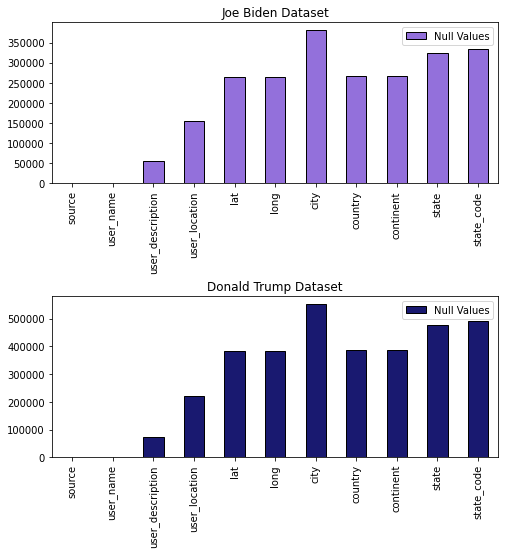

In [ ]:
def hide_axes(this_ax):
    this_ax.set_frame_on(False)
    this_ax.set_xticks([])
    this_ax.set_yticks([])
    return this_ax

def draw_heatmap1(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap1_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap2(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap2_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def draw_heatmap3(df,this_ax):
    hm = sns.heatmap(df, ax = this_ax, **heatmap3_args)
    this_ax.set_yticklabels(this_ax.get_yticklabels(), rotation=0)
    this_ax.yaxis.tick_right()
    this_ax.yaxis.set_label_position("right")
    for axis in ['top','bottom','left','right']:
        this_ax.spines[axis].set_visible(True)
        this_ax.spines[axis].set_color('black')
    return hm

def thousands1(x, pos):
    'The two args are the value and tick position'
    return '%1.0fK' % (x * 1e-3)

formatterK1 = FuncFormatter(thousands1)

def thousands2(x, pos):
    'The two args are the value and tick position'
    return '%1.1fK' % (x * 1e-3)

formatterK2 = FuncFormatter(thousands2)

na_vals_b=pd.DataFrame({'Null Values':tweets_biden.isna().sum()})
na_vals_b=na_vals_b.loc[na_vals_b['Null Values'] > 0]
na_vals_t=pd.DataFrame({'Null Values':tweets_trump.isna().sum()})
na_vals_t=na_vals_t.loc[na_vals_t['Null Values'] > 0]

# Null values visualisation for tweets about Joe Biden and Donald Trump
fig, ax=plt.subplots(2,1, figsize=(8,8), gridspec_kw={'hspace':0.7})

na_vals_b.plot.bar(color='mediumpurple', **barstyle, ax=ax[0])
ax[0].set_title('Joe Biden Dataset')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

na_vals_t.plot.bar(color='midnightblue', **barstyle, ax=ax[1])
ax[1].set_title('Donald Trump Dataset')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)
plt.show()


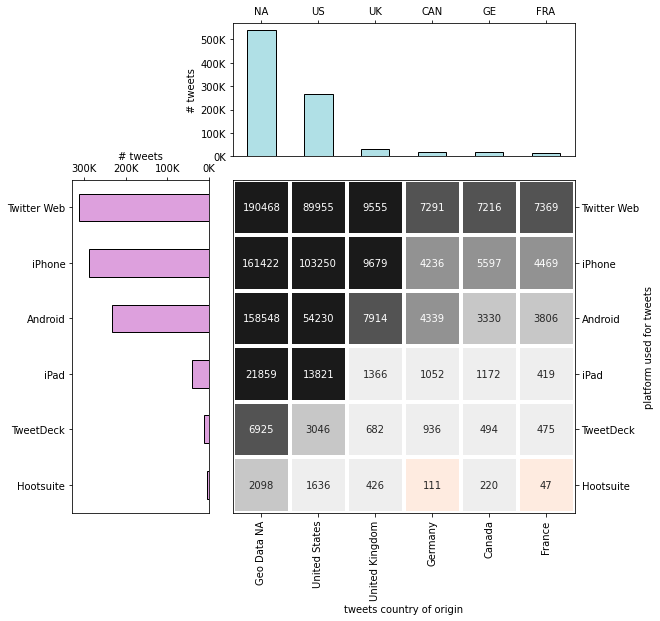

In [ ]:
source_df=pd.concat([tweets_biden[['source','tweet','country']].copy(),tweets_trump[['source','tweet','country']].copy()])
source_df['country'].replace({'United States of America':'United States'}, inplace=True)
source_df=source_df.fillna('Geo Data NA')
source_df=source_df.drop_duplicates()

sources=pd.DataFrame(source_df.groupby(['source'])['tweet'].count().sort_values(ascending=False)[:6])
sources=sources.reset_index()
sourceslst=sources.source.to_list()

country=pd.DataFrame(source_df.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:6])
country=country.reset_index()
countrylst=country.country.to_list()

platXtab=pd.DataFrame(source_df.groupby(['source','country'])['tweet'].count().unstack().fillna(0))

fig, ax=plt.subplots(2,2, figsize=(9,9),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap1(platXtab.loc[sourceslst,countrylst], hm_ax)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('platform used for tweets')
hm_ax.set_yticklabels(('Twitter Web','iPhone','Android','iPad','TweetDeck','Hootsuite'), rotation=0)

bar_ax = ax[0,1]
platXtab.loc[sourceslst,countrylst].sum().plot.bar(ax=bar_ax, color = 'powderblue',**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.yaxis.set_major_formatter(formatterK1)
bar_ax.set_xticklabels(('NA', 'US', 'UK', 'CAN', 'GE','FRA'), rotation=0)
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# tweets')

barh_ax = ax[1,0]
platXtab.loc[sourceslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color='plum',**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK1)
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_yticklabels(('Hootsuite','TweetDeck','iPad','Android','iPhone','Twitter Web'), rotation=0)
barh_ax.set_xlabel('# tweets')
barh_ax.set_ylabel('')
plt.show()

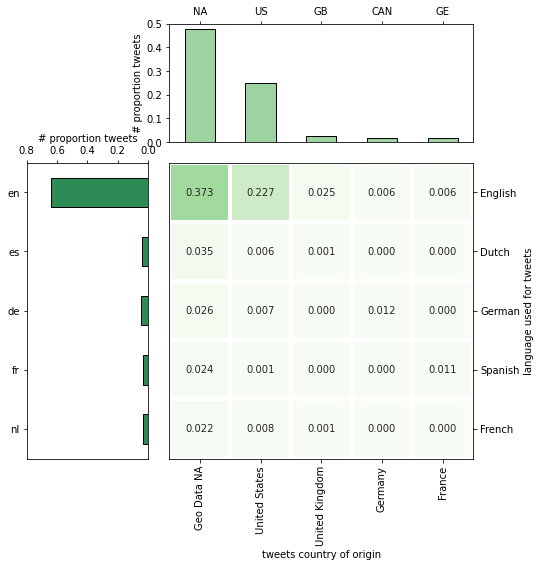

In [ ]:
def detect_tweetlang(tweet):
    try:
        return detect(tweet)
    except:
        return 'unknown'

# Combine two data files and drop duplicates
lang_df=pd.concat([tweets_biden[['tweet','country']].copy(),tweets_trump[['tweet','country']].copy()])
lang_df['country'].replace({'United States of America':'United States'}, inplace=True)
lang_df=lang_df.fillna('Geo Data NA')
lang_df=lang_df.drop_duplicates()

# Randomly sample data for langauge analysis
lang_smdf=lang_df.sample(n=4000).copy()
lang_smdf['lang'] = lang_smdf['tweet'].apply(detect_tweetlang)

# Select top five languages and five countries for heatmap
langs=pd.DataFrame(lang_smdf.groupby(['lang'])['tweet'].count().sort_values(ascending=False)[:5])
langs=langs.reset_index()
langslst=langs.lang.to_list()

country=pd.DataFrame(lang_smdf.groupby(['country'])['tweet'].count().sort_values(ascending=False)[:5])
country=country.reset_index()
countrylst=country.country.to_list()

# Create a crosstab to feed data to heatmap
langXtab=pd.crosstab(lang_smdf.lang, lang_smdf.country, normalize=True)

fig, ax=plt.subplots(2,2, figsize=(8,8),
                     gridspec_kw={'height_ratios':[2,5], 'width_ratios':[2,5], 'wspace':0.1, 'hspace':0.1})

hide_ax = ax[0,0]
hide_axes(hide_ax)

hm_ax = ax[1,1]
draw_heatmap2(langXtab.loc[langslst,countrylst], hm_ax)
hm_ax.set_yticklabels(('English', 'Dutch', 'German','Spanish','French'), rotation=0)
hm_ax.set_xlabel('tweets country of origin')
hm_ax.set_ylabel('language used for tweets')

bar_ax = ax[0,1]
langXtab.loc[langslst,countrylst].sum().plot.bar(ax=bar_ax, color=barcolors[1],**barstyle)
bar_ax.set_xlabel(bar_ax.get_xlabel())
bar_ax.xaxis.tick_top()
bar_ax.xaxis.set_label_position("top")
bar_ax.set_xticklabels(('NA','US', 'GB', 'CAN', 'GE'), rotation=0)
bar_ax.set_ylim([0, 0.5])
bar_ax.set_xlabel('')
bar_ax.set_ylabel('# proportion tweets')

barh_ax = ax[1,0]
langXtab.loc[langslst,countrylst].sum(axis=1)[::-1].plot.barh(ax=barh_ax, color=barcolors[5],**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlim([0.8, 0])
barh_ax.set_xlabel('# proportion tweets')
barh_ax.set_ylabel('')
barh_ax.set_yticklabels(langslst[::-1], rotation=0)

plt.show()

In [ ]:
# Identify the common UserId's in both datasets and create tables for feed visualisation
common_ids=np.intersect1d(tweets_biden.user_id, tweets_trump.user_id)
unique_b=tweets_biden[~tweets_biden.user_id.isin(common_ids)].copy()
common_b=tweets_biden[tweets_biden.user_id.isin(common_ids)].copy()
unique_t=tweets_trump[~tweets_trump.user_id.isin(common_ids)].copy()
common_t=tweets_trump[tweets_trump.user_id.isin(common_ids)].copy()

common_df=pd.concat([common_b,common_t])
common_df=common_df.drop_duplicates()

# Create columns for visualiation
unique_b['usertype'] = 'Biden'
unique_t['usertype'] = 'Trump'
common_df['usertype'] = 'Both'

# Narrow down data
cont_df=pd.concat([unique_b[['tweet','continent','usertype']].copy(),
                   unique_t[['tweet','continent','usertype']].copy(),
                   common_df[['tweet','continent','usertype']].copy()])

# Label NA Geo Data
cont_df=cont_df.fillna('Geo Data NA')

# Calculate tweet counts for each usertype and continuent
usertype=pd.DataFrame(cont_df.groupby(['usertype'])['tweet'].count().sort_values(ascending=False))
usertype=usertype.reset_index()
userlst=usertype.usertype.tolist()

continent=pd.DataFrame(cont_df.groupby(['continent'])['tweet'].count().sort_values(ascending=False)[:6])
continent=continent.reset_index()
contlst=continent.continent.to_list()

# Create crosstab to feed heatmap
contXtab=pd.crosstab(cont_df.continent, cont_df.usertype)


<ipython-input-11-09037d03b265>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df['usertype'] = 'Both'


In [ ]:
# Identify common tweet creation dates
common_creat=np.intersect1d(tweets_biden.created_at_r, tweets_trump.created_at_r)

# Mask out data to ensure common lenth arrays to feed visualisation
cnt_tbiden=tweets_biden[tweets_biden.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()
cnt_ttrump=tweets_trump[tweets_trump.created_at_r.isin(common_creat)]['created_at_r'].value_counts().sort_index()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


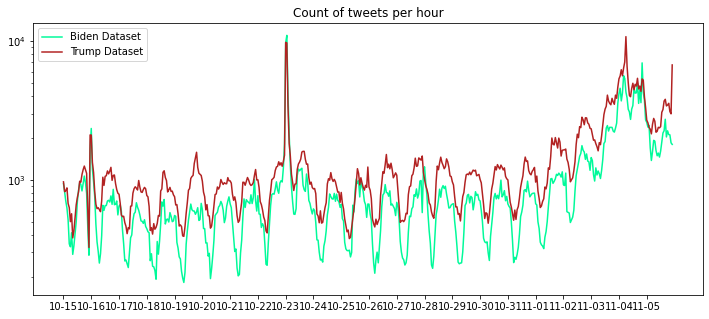

In [ ]:
plt.figure(figsize=(12,5))
p6=sns.lineplot(cnt_tbiden.index, cnt_tbiden.values, color='mediumspringgreen', label='Biden Dataset')
p6.set_title('Count of tweets per hour')
p6=sns.lineplot(cnt_ttrump.index, cnt_ttrump.values, color='firebrick', label='Trump Dataset')
p6.set_xticks(range(0, len(cnt_tbiden.index), 24))
p6.set_xticklabels(common_df['created_at'].dt.strftime('%m-%d').unique().tolist())
p6.set_yscale('log')
plt.show()

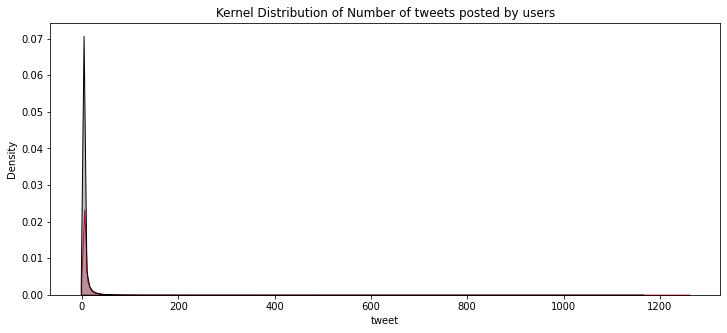

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
line_ax = ax
line_ax.set_title('Kernel Distribution of Number of tweets posted by users')
sns.kdeplot(tweets_biden.groupby(['user_id'])['tweet'].count(), shade=True, color='crimson', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump.groupby(['user_id'])['tweet'].count(), shade=True, color='black', label='Trump Dataset', ax=line_ax)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


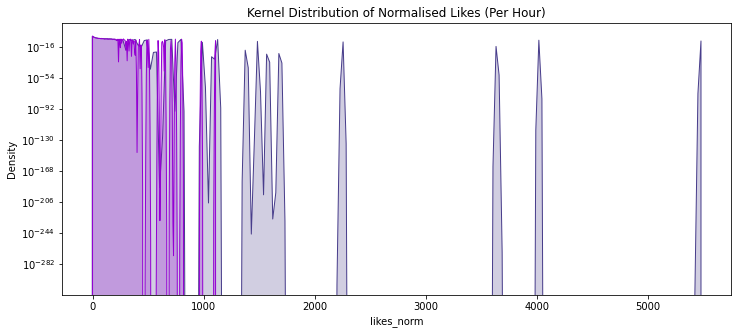

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))

line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Likes (Per Hour)')
sns.kdeplot(tweets_biden['likes_norm'],bw=0.1, shade=True, color='darkslateblue', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['likes_norm'],bw=0.1, shade=True, color='darkviolet', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.1 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


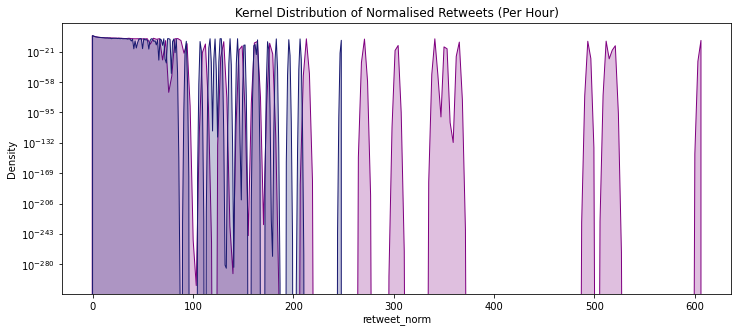

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
line_ax = ax
line_ax.set_title('Kernel Distribution of Normalised Retweets (Per Hour)')
sns.kdeplot(tweets_biden['retweet_norm'],bw=0.1, shade=True, color='purple', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['retweet_norm'],bw=0.1, shade=True, color='midnightblue', label='Trump Dataset', ax=line_ax)
line_ax.set_yscale('log')
plt.show()

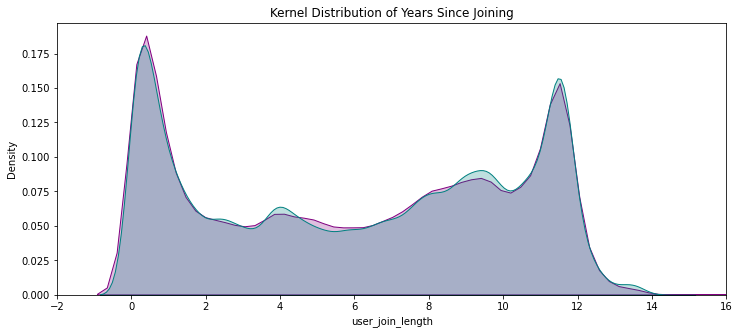

In [ ]:
fig, ax=plt.subplots(1,1, figsize=(12,5))
tweets_biden['user_join_length'] = max(tweets_biden['created_at']) - tweets_biden['user_join_date']
tweets_trump['user_join_length'] = max(tweets_trump['created_at']) - tweets_trump['user_join_date']

line_ax = ax
plt.xlim(-2, 16)
line_ax.set_title('Kernel Distribution of Years Since Joining')
sns.kdeplot(tweets_biden['user_join_length'].dt.days/365.25, shade=True, color='purple', label='Biden Dataset', ax=line_ax)
sns.kdeplot(tweets_trump['user_join_length'].dt.days/365.25, shade=True, color='teal', label='Trump Dataset', ax=line_ax)
plt.show()

In [ ]:
# Obtain tweets only from data that has Geo Data from the US
text1=tweets_biden.loc[tweets_biden['country'] == 'United States of America']['tweet']
text2=tweets_trump.loc[tweets_trump['country'] == 'United States of America']['tweet']

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
def clean1(sent):
    filtered_sent=""
    stopwords = nltk.corpus.stopwords.words('english')
    sent = (unicodedata.normalize('NFKD', sent)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    sent = re.sub(r'#.+|https.+|[^(a-zA-Z)\s]','',sent)
    words=sent.split()
    for word in words:
        if word not in stopwords:
            filtered_sent=filtered_sent+' '+word
    return filtered_sent

def clean2(text):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

words1 = clean2(''.join(str(text1.apply(clean1).tolist())))
words2 = clean2(''.join(str(text2.apply(clean1).tolist())))
words1[:10]

['islandgirlprv',
 'bradbeauregardj',
 'meidastouch',
 'ccp',
 'thats',
 'always',
 'fine',
 'jack',
 'vijaya',
 'dickc']

In [ ]:
# Obtain top 10 Bi and Tri Ngrams from cleaned data
biden_2ngrams=(pd.Series(nltk.ngrams(words1, 2)).value_counts())[:10]
trump_2ngrams=(pd.Series(nltk.ngrams(words2, 2)).value_counts())[:10]
biden_3ngrams=(pd.Series(nltk.ngrams(words1, 3)).value_counts())[:10]
trump_3ngrams=(pd.Series(nltk.ngrams(words2, 3)).value_counts())[:10]

# Input Bi and Tri Ngrams into dataframes for plotting
biden_ngrams=pd.concat([biden_2ngrams,biden_3ngrams])
trump_ngrams=pd.concat([trump_2ngrams,trump_3ngrams])

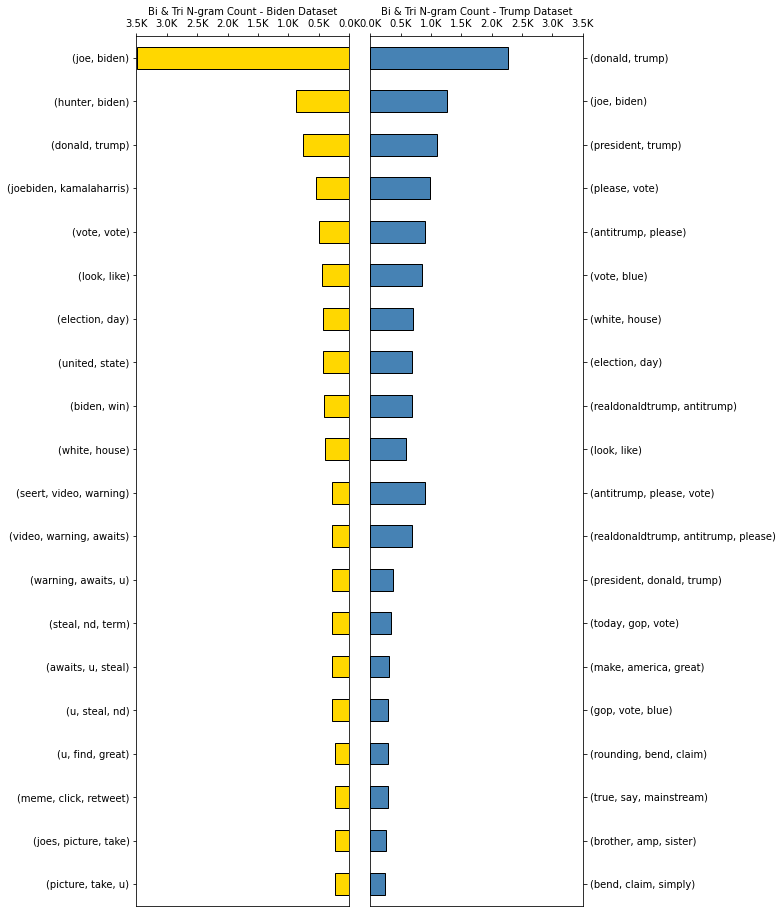

In [ ]:
fig, ax=plt.subplots(1,2, figsize=(8,16),
                     gridspec_kw={'width_ratios':[1,1], 'wspace':0.1, 'hspace':0.1})

barh_ax = ax[0]
biden_ngrams[::-1].plot.barh(ax=barh_ax, color='gold',**barstyle)
barh_ax.yaxis.set_label_position("left")
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim()[::-1])
barh_ax.set_xlabel('Bi & Tri N-gram Count - Biden Dataset')
barh_ax.set_ylabel('')

barh_ax = ax[1]
trump_ngrams[::-1].plot.barh(ax=barh_ax, color="steelblue",**barstyle)
barh_ax.xaxis.tick_top()
barh_ax.xaxis.set_label_position("top")
barh_ax.xaxis.set_major_formatter(formatterK2)
barh_ax.set_xlim([0, 3500])
barh_ax.set_xlim(barh_ax.get_xlim())
barh_ax.yaxis.tick_right()
barh_ax.set_xlabel('Bi & Tri N-gram Count - Trump Dataset')
barh_ax.set_ylabel('')
plt.show()

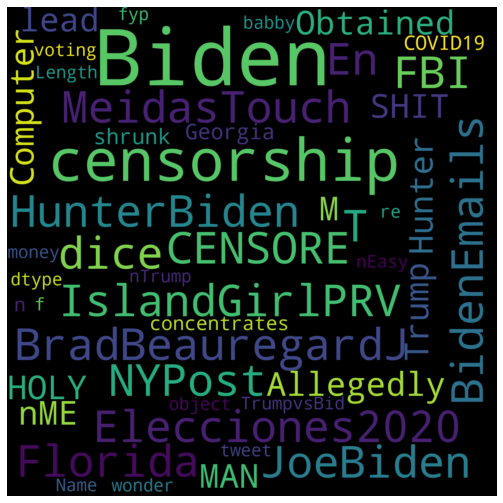

In [ ]:
plt.subplots(1,1, figsize=(9,9))
wc_b = WordCloud(stopwords=STOPWORDS,
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_b.generate(str(text1.dropna()))
plt.imshow(wc_b, interpolation="bilinear")
plt.axis('off')
plt.show()

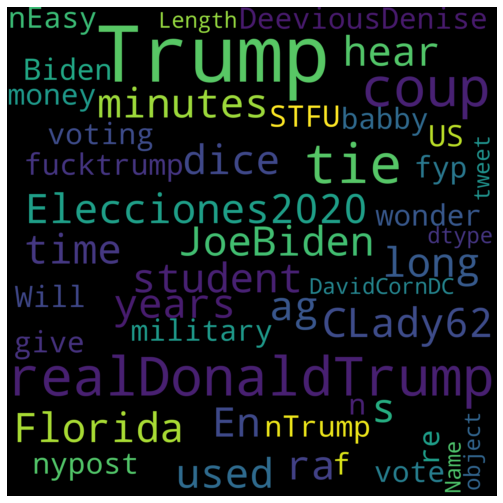

In [ ]:
plt.subplots(1,1, figsize=(9,9))
wc_t = WordCloud(stopwords=STOPWORDS,
                 background_color="black", max_words=2000,
                 max_font_size=256, random_state=42,
                 width=1600, height=1600)
wc_t.generate(str(text2.dropna()))
plt.imshow(wc_t, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
# Obtain sentiment scores for both datasets
sid = SentimentIntensityAnalyzer()
tweets_biden['VADAR']=sentiment(tweets_biden['tweet'])
tweets_trump['VADAR']=sentiment(tweets_trump['tweet'])
tweets_biden['compound']  = tweets_biden['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['compound']  = tweets_trump['VADAR'].apply(lambda score_dict: score_dict['compound'])
tweets_trump['sentiment']  = tweets_trump['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))
tweets_biden['sentiment']  = tweets_biden['compound'].apply(lambda x: 'pos' if x > 0.05 else ('neg' if x < -0.05 else 'neu'))

# Create 52 state set
states=set(tweets_biden.loc[tweets_biden['country'] == 'United States of America']['state'].dropna())
states.remove('District of Columbia')
states.remove('Northern Mariana Islands')

# Create feature to allow masking of data and then mask data for votable states
tweets_biden['voting_rights']=tweets_biden['state'].apply(lambda x: 'Yes' if x in states else 'No')
tweets_trump['voting_rights']=tweets_trump['state'].apply(lambda x: 'Yes' if x in states else 'No')
sent_t=tweets_trump.loc[tweets_trump['voting_rights'] == 'Yes']
sent_b=tweets_biden.loc[tweets_biden['voting_rights'] == 'Yes']

# Further mask data for only the last 14 days
state_b=sent_b.loc[sent_b['created_at'] > max(sent_b['created_at']) - timedelta(14)]
state_t=sent_t.loc[sent_t['created_at'] > max(sent_t['created_at']) - timedelta(14)]
state_b_mean=state_b.groupby('state')['compound'].mean().reset_index()
state_t_mean=state_t.groupby('state')['compound'].mean().reset_index()

# Further mask data for only the last 14 days
state_bp=sent_b.loc[sent_b['created_at'] < min(sent_b['created_at']) + timedelta(14)]
state_tp=sent_t.loc[sent_t['created_at'] < min(sent_t['created_at']) + timedelta(14)]
state_bp_mean=state_bp.groupby('state')['compound'].mean().reset_index()
state_tp_mean=state_tp.groupby('state')['compound'].mean().reset_index()

# Create dataframe for visualisation
states_sent=pd.DataFrame({'state':state_b_mean['state'],
                          'biden1':state_b_mean['compound'],
                          'trump1':state_t_mean['compound'],
                          'biden2':state_bp_mean['compound'],
                          'trump2':state_tp_mean['compound'],})


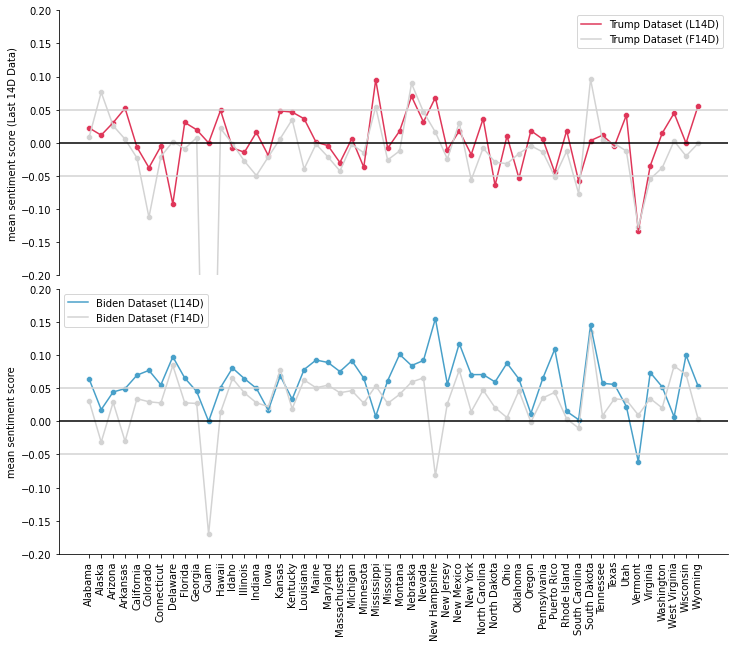

In [ ]:
fig, ax=plt.subplots(2,1, figsize=(12,10), gridspec_kw={'hspace':0.05})
lineax=ax[0]
sns.lineplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax, label='Trump Dataset (L14D)')
sns.scatterplot(x='state', y='trump1', color=barcolors[6], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax, label='Trump Dataset (F14D)')
sns.scatterplot(x='state', y='trump2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score (Last 14D Data)')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax=ax[1]
sns.lineplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax, label='Biden Dataset (L14D)')
sns.scatterplot(x='state', y='biden1', color=barcolors[3], data=states_sent, ax=lineax)
sns.lineplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax, label='Biden Dataset (F14D)')
sns.scatterplot(x='state', y='biden2', color='lightgrey', data=states_sent, ax=lineax)
lineax.set_ylim([-0.2, 0.2])
lineax.set_ylabel('mean sentiment score')
lineax.set_xlabel('')
plt.xticks(rotation=90)
lineax.axhline(y=0, color='k', linestyle='-')
lineax.axhline(y=0.05, color='lightgrey', linestyle='-')
lineax.axhline(y=-0.05, color='lightgrey', linestyle='-')
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
plt.show()

In [ ]:
# Calculate counts of sentiments
stack_t=sent_t.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()
stack_b=sent_b.groupby(['created_at_r','sentiment'])['tweet'].count().reset_index()

# Setup np.arrays to allow quick calculations of the proportions of tweet sentiments
a1=np.array(stack_b.loc[stack_b.sentiment == 'pos']['tweet'].tolist())
b1=np.array(stack_b.loc[stack_b.sentiment == 'neu']['tweet'].tolist())
c1=np.array(stack_b.loc[stack_b.sentiment == 'neg']['tweet'].tolist())
d1=np.array(stack_b.groupby('created_at_r')['tweet'].sum().tolist())

a2=np.array(stack_t.loc[stack_t.sentiment == 'pos']['tweet'].tolist())
b2=np.array(stack_t.loc[stack_t.sentiment == 'neu']['tweet'].tolist())
c2=np.array(stack_t.loc[stack_t.sentiment == 'neg']['tweet'].tolist())
d2=np.array(stack_t.groupby('created_at_r')['tweet'].sum().tolist())

# Calculate sentiment proportions and feed into dataframes for visualisation
SentiDat_b=pd.DataFrame({'date':pd.to_datetime(stack_b.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_b.created_at_r.unique()),
                         'pos':a1/d1,'neu':b1/d1,'neg':c1/d1})

SentiDat_t=pd.DataFrame({'date':pd.to_datetime(stack_t.created_at_r.unique()),
                         'datenum':dates.datestr2num(stack_t.created_at_r.unique()),
                         'pos':a2/d2,'neu':b2/d2,'neg':c2/d2})


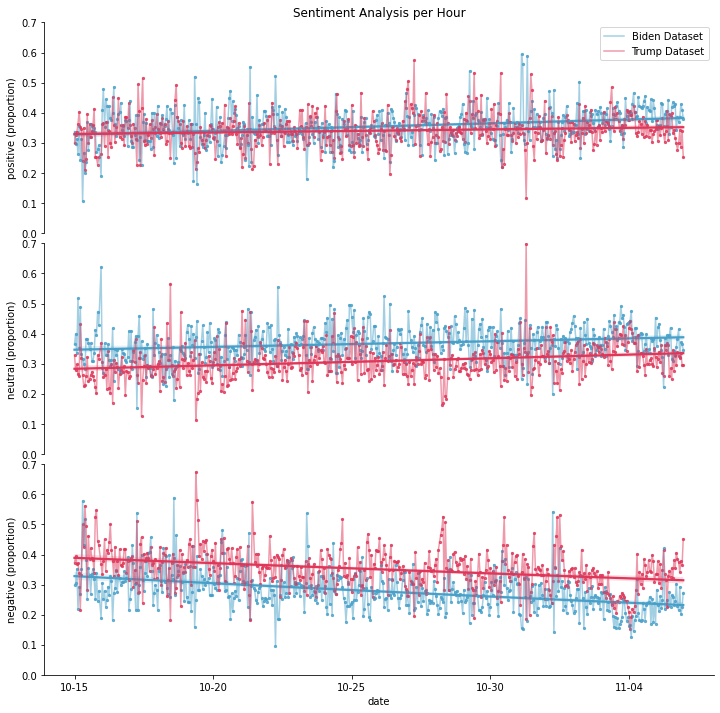

In [ ]:
def fake_dates(x, pos):
    """ Custom formater to turn floats into e.g., 05-08"""
    return dates.num2date(x).strftime('%m-%d')

fig, ax=plt.subplots(3,1, figsize=(12,12), gridspec_kw={'hspace':0.05})

# Plot
lineax=ax[0]
lineax.set_title('Sentiment Analysis per Hour')
sns.regplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_b, ax=lineax, color=barcolors[3], alpha=0.5, label='Biden Dataset')
sns.regplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='pos', data=SentiDat_t, ax=lineax, color=barcolors[6], alpha=0.5, label='Trump Dataset')
lineax.xaxis.set_major_formatter(fake_dates)
lineax.set_ylim([0, 0.7])
lineax.set_xlabel('')
lineax.set_ylabel('positive (proportion)')
lineax.axes.get_xaxis().set_ticks([])
lineax.spines['right'].set_visible(False)
lineax.spines['top'].set_visible(False)
lineax.spines['bottom'].set_visible(False)

lineax1=ax[1]
sns.regplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_b, ax=lineax1, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neu', data=SentiDat_t, ax=lineax1, color=barcolors[6], alpha=0.5)
lineax1.xaxis.set_major_formatter(fake_dates)
lineax1.set_ylim([0, 0.7])
lineax1.set_xlabel('')
lineax1.set_ylabel('neutral (proportion)')
lineax1.axes.get_xaxis().set_ticks([])
lineax1.spines['right'].set_visible(False)
lineax1.spines['top'].set_visible(False)
lineax1.spines['bottom'].set_visible(False)

lineax2=ax[2]
sns.regplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_b, ax=lineax2, color=barcolors[3], alpha=0.5)
sns.regplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], scatter_kws={'s':5}, logistic=True, ci=95)
sns.lineplot(x='datenum',y='neg', data=SentiDat_t, ax=lineax2, color=barcolors[6], alpha=0.5)
lineax2.xaxis.set_major_formatter(fake_dates)
lineax2.set_ylim([0, 0.7])
lineax2.set_ylabel('negative (proportion)')
lineax2.set_xlabel('date')
lineax2.spines['right'].set_visible(False)
lineax2.spines['top'].set_visible(False)

plt.show()